In [74]:
from utils import *

In [65]:
temperature = parse_file('data/pcu1/Supply trafo A winding 2W temp.csv', 'temp')
auxiliaries = parse_file('data/pcu1/AUX ON from PCU.csv', 'aux')
current = parse_file('data/pt1/i1.csv', 'I')

In [102]:
aux = auxiliaries.copy()
aux['aux_off'] = 1 - auxiliaries['aux']

curr = current.copy()
curr['I2'] = curr['I']**2
cols = ['I', 'I2']
curr[cols] = scale(curr[cols], with_std=True, with_mean=True)

temp = temperature.copy()
temp_mean = temp['temp']
temp = scale(temp, with_std=True, with_mean=True)
s, u = temperature.std(axis=0), temperature.mean(axis=0)

X, y = make_design_matrix(aux, curr, temp, 9)

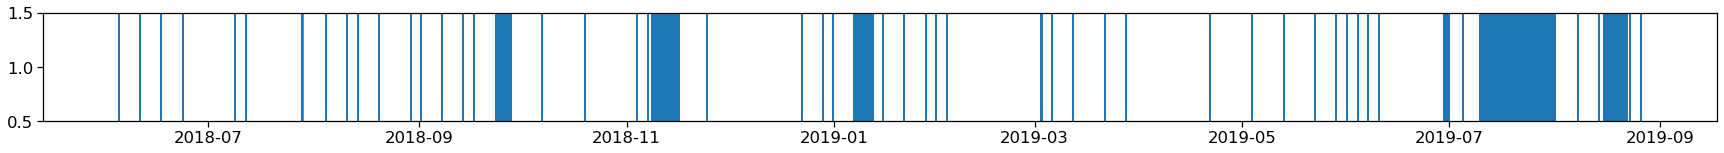

In [53]:
T = sample_gaps(X)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,2))
#axes.stem(T.index, T['gap'], markerfmt=' ', basefmt=' ')
axes.eventplot(T.index, orientation='horizontal')
axes.set_ylim(.5,1.5)
plt.show()

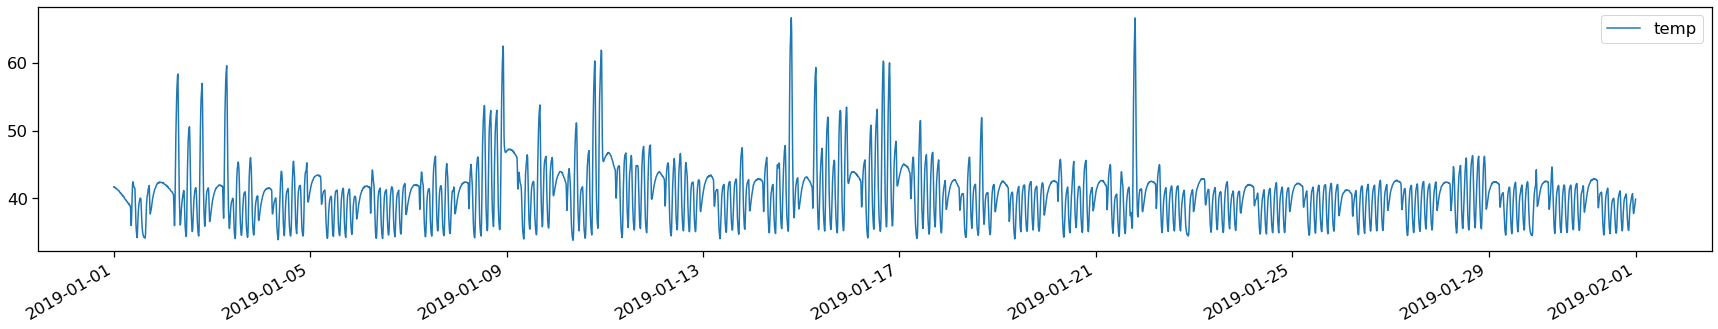

In [108]:
(temp*s+u)['2019-01-01 00:00:00':'2019-02-01 00:00:00'].plot(figsize=(30,5))
plt.show()

In [103]:
b = ols(X, y, start=None, end='2018-09-01 00:00:00')
b

array([[-7.16895325e-02],
       [ 9.44698569e-02],
       [ 4.28159426e-04],
       [ 1.36887576e-01],
       [ 1.80171324e+00],
       [-1.22347828e+00],
       [ 2.29947305e-01],
       [ 3.35020882e-01],
       [-3.06179433e-01],
       [ 5.35625564e-02],
       [ 4.43190668e-02],
       [-8.90097571e-02],
       [ 6.52365613e-02]])

R2=0.926


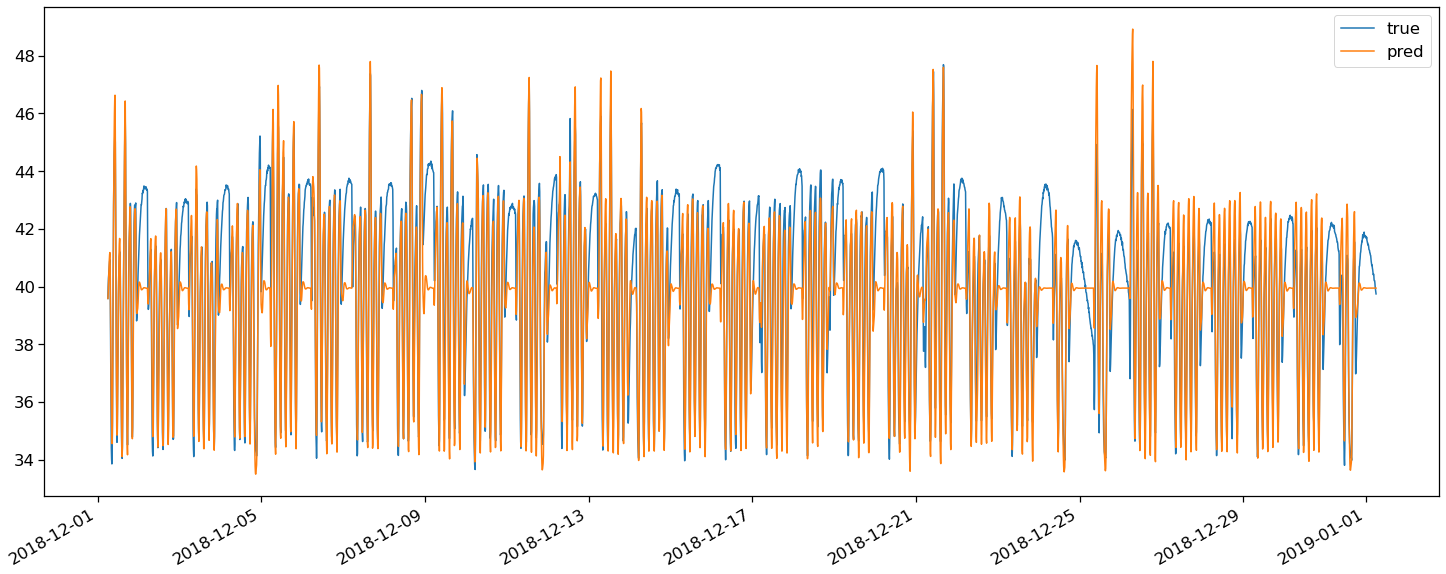

In [119]:
start = '2018-12-01 06:00:00'
end = '2019-01-12 22:00:00'
end = np.datetime64(start) + np.timedelta64(31, 'D')

y_true = y[start:end]
y_pred = evaluate(b, X, y[start:end]['temp'][0], start=start, end=end)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
ax = axes
(y_true*s+u).plot(ax=ax)
(y_pred*s+u).plot(ax=ax)

r2 = skl.metrics.r2_score(y_true.between_time('06:00:00', '22:00:00'), y_pred.between_time('06:00:00', '22:00:00'))
print(f'R2={r2:.3f}')

ax.legend(['true', 'pred'])
plt.show()